In [2]:
import math
import itertools
import numpy as np
import sys
import copy
import random
import matplotlib.pyplot as plt

In [3]:
MRPs = {
    'Milk': 50,
    'Bread': 20,
    'Eggs': 50,
    'Rice': 500,
    'Chicken': 100,
    'Potatoes': 30,
    'Bananas': 35,
    'Tomatoes': 216,
    'Onions': 50,
    'Salt': 30,
    'Sugar': 60,
    'Oil': 89,
    'Flour': 73,
    'Tea': 40,
    'Coffee': 85,
    'Soap': 30,
    'Toothpaste': 60,
    'Shampoo': 120,
    'Toilet Paper': 55,
    'Tissues': 99
}

Items = []
Prices = []
for item,price in MRPs.items():
  Items.append(item)
  Prices.append(price)

In [4]:
# Defining Locations in the city of Prayagraj
class Location:
  def __init__(self, lat, lon):
    self.lat = lat
    self.lon = lon

Prayagraj = Location(25.4358 , 81.8463)
no_shops = 7
locations=[]
for _ in range(no_shops):
    offset_lat = random.uniform(-20000/111000, 20000/111000)
    offset_lon = random.uniform(-20000/111000, 20000/111000)

    locations.append(Location(Prayagraj.lat+offset_lat, Prayagraj.lon+offset_lon))

print((locations[1].lat, locations[1].lon))

(25.553211816807913, 82.00444957987564)


In [5]:
# Function to calculate the distance between two locations with given latitude and longitude
def haversine_distance(loc1, loc2):
    # Radius of the Earth in meters
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(loc1.lat)
    lon1 = math.radians(loc1.lon)
    lat2 = math.radians(loc2.lat)
    lon2 = math.radians(loc2.lon)

    # Calculate the change in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Calculate the distance
    distance = R * c

    return distance

In [6]:
Dis_matrix =  np.zeros((7,7))
for i in range(7):
  for j in range(i,7):
    Dis_matrix[i][j] = haversine_distance(locations[i],locations[j])
    Dis_matrix[j][i] = Dis_matrix[i][j]

Dis_matrix

array([[ 0.        , 39.52895178, 26.4024842 , 25.57627908, 10.96384807,
        26.88567896, 25.11081227],
       [39.52895178,  0.        , 13.16589104, 17.89723198, 35.22373414,
        13.01731595, 16.26250949],
       [26.4024842 , 13.16589104,  0.        ,  9.99966384, 22.50568094,
         1.76057014,  7.07168271],
       [25.57627908, 17.89723198,  9.99966384,  0.        , 25.95215657,
        11.7596464 ,  2.95052073],
       [10.96384807, 35.22373414, 22.50568094, 25.95215657,  0.        ,
        22.26242525, 24.29488181],
       [26.88567896, 13.01731595,  1.76057014, 11.7596464 , 22.26242525,
         0.        ,  8.82866974],
       [25.11081227, 16.26250949,  7.07168271,  2.95052073, 24.29488181,
         8.82866974,  0.        ]])

In [7]:
no_items = random.randint(1,20) #for a random order from customers
no_items = 4
items=random.sample(Items,no_items)
print(items)

actions=range(no_shops)

#Bernoulli variable for each shop
bernoulli=np.random.rand(no_shops,no_items)

#Price bias for each shop
discount=abs(np.random.normal(0,15,no_shops))

print(bernoulli)
print(discount)

['Salt', 'Bread', 'Onions', 'Potatoes']
[[0.24036346 0.25495881 0.88535216 0.88762623]
 [0.04372523 0.52760162 0.41113753 0.63611163]
 [0.63797696 0.04437798 0.92466094 0.57160752]
 [0.06391083 0.08696804 0.33526294 0.29786303]
 [0.80385818 0.03456389 0.33494885 0.61911266]
 [0.46179876 0.84509252 0.75495705 0.55021614]
 [0.15659656 0.69901436 0.01210504 0.19037713]]
[ 0.13131012 19.47961407 31.66982494 33.53978348  1.05124822 19.14093441
 12.91330476]


In [8]:
#Creating State Space
class State:
    def __init__(self, shop, status):
        self.shop = shop
        self.status = status

state_space = []
buying_statuses = list(itertools.product([0, 1], repeat=no_items))

for shop_no in range(no_shops):
    for status in buying_statuses:
      state = State(shop_no, status)
      state_space.append(state)

print('State Space Size', len(state_space))
print(f'State representation:\n  Shop \t        status \n   {state_space[0].shop} \t {state_space[0].status}' )

State Space Size 112
State representation:
  Shop 	        status 
   0 	 (0, 0, 0, 0)


In [9]:
def reward(current_state,next_state, distance):
  current_status = current_state.status
  next_status = next_state.status

  bought_count = 0
  money_spent = 0
  for i in range(no_items):
    if(current_status[i]==0 and next_status[i]==1):
      money_spent += MRPs[items[i]]
      bought_count += 1

  return (40 - distance) + bought_count*10 + money_spent * discount[next_state.shop] * 0.01

In [10]:
def distance_penalty(current_state,next_state, distance):
  current_status = current_state.status
  next_status = next_state.status

  empty_handed_count = 0
  for i in range(no_items):
    if(not(next_status[i])):
      empty_handed_count += 1

  return -(distance + empty_handed_count*10)

In [11]:
def availability_in_shop(current_state,next_state):
    old_status=current_state.status
    new_status=next_state.status
    next_shop=next_state.shop
    prob=1

    for item_no in range(len(old_status)):
        if old_status[item_no]==0:
            if new_status[item_no]==0:
                prob=prob*(1-bernoulli[next_shop][item_no])
            else:
                prob=prob*bernoulli[next_shop][item_no]
        else:
            if new_status[item_no]==0:
                prob=0

    return prob

def M(currnet_shop,next_shop):
    temp=sum(sum(np.triu(Dis_matrix)))
    temp2=(temp-Dis_matrix[currnet_shop,next_shop])/((no_shops-1)*temp)
    return temp2

In [12]:
net = list(itertools.product(state_space,actions,state_space))

In [13]:
len(net)

87808

In [14]:
#Defining Transition Probabilities and Rewards
P=dict()
R=dict()

actions=range(no_shops)
for current_state, action, next_state in net:

  # All the items already bought
    if current_state.status==tuple(np.ones(no_items, dtype=int)):
        P[(current_state, action, next_state)] = 0
        R[(current_state, action, next_state)] = None
        continue

    if action == current_state.shop: #action==current_shop
        if next_state.shop!=current_state.shop:
            P[(current_state, action, next_state)] = 0
            R[(current_state, action, next_state)] = None

        else:
            P[(current_state, action, next_state)] = availability_in_shop(current_state, next_state)
            R[(current_state, action, next_state)] = reward(current_state, next_state, Dis_matrix[current_state.shop][next_state.shop]) + distance_penalty(current_state, next_state, Dis_matrix[current_state.shop][next_state.shop])
    else:
        if action == next_state.shop:
            P[(current_state, action, next_state)] = 0.9*availability_in_shop(current_state, next_state)
            R[(current_state, action, next_state)] = reward(current_state, next_state, Dis_matrix[current_state.shop][next_state.shop]) + distance_penalty(current_state, next_state, Dis_matrix[current_state.shop][next_state.shop])

        else:
            P[(current_state, action, next_state)] = 0.1 * availability_in_shop(current_state, next_state) * M(current_state.shop, next_state.shop)
            R[(current_state, action, next_state)]=reward(current_state, next_state, Dis_matrix[current_state.shop][next_state.shop]) + distance_penalty(current_state, next_state, Dis_matrix[current_state.shop][action]+Dis_matrix[action][next_state.shop])

    print ("Next transition")
    print (current_state, action, next_state, P[(current_state, action, next_state)],R[(current_state, action, next_state)])

Streaming output truncated to the last 5000 lines.
Next transition
<__main__.State object at 0x7efc68e28af0> 5 <__main__.State object at 0x7efc68e39690> 0.0 -25.175727157112593
Next transition
<__main__.State object at 0x7efc68e28af0> 5 <__main__.State object at 0x7efc68e386a0> 0.0 -15.175727157112593
Next transition
<__main__.State object at 0x7efc68e28af0> 5 <__main__.State object at 0x7efc68e3ad10> 0.0 -15.175727157112593
Next transition
<__main__.State object at 0x7efc68e28af0> 5 <__main__.State object at 0x7efc68e38340> 0.0005399402643639872 -5.175727157112593
Next transition
<__main__.State object at 0x7efc68e28af0> 5 <__main__.State object at 0x7efc68e3a710> 0.0 -17.657339474342578
Next transition
<__main__.State object at 0x7efc68e28af0> 5 <__main__.State object at 0x7efc68e3afb0> 0.0 -7.657339474342578
Next transition
<__main__.State object at 0x7efc68e28af0> 5 <__main__.State object at 0x7efc68e387c0> 0.0 -7.657339474342578
Next transition
<__main__.State object at 0x7efc68e2

In [15]:
def takeaction(current_state,action):
    global P
    global R
    global state_space
    r = random.random()
    for next_state in state_space:
        if(r<=0):
            break
        r-=P[(current_state,action,next_state)]
    return next_state, R[(current_state,action,next_state)]

In [16]:
def e_greedy(e,Q_s):
    x=random.randrange(1,11)
    if x<=e*10:
        return random.randrange(no_shops)
    else:
        return np.argmax(Q_s)

In [17]:
def q_learning(no_episodes,no_steps,alpha,gamma,epsilon):
    Q = dict()
    Rewards = []
    avg_rewards = []

    for e in range(no_episodes):
        S = random.choice(state_space)
        step = 0
        Episode_Reward = 0

        while(step<no_steps):
            if S not in Q.keys():
                Q[S] = np.zeros(no_shops).astype(int)
            if S.status == tuple(np.ones(no_items, dtype = 'int')):
                break

            A = e_greedy(epsilon,Q[S])
            S_,r = takeaction(S,A)

            if S_ not in Q.keys():
                Q[S_] = np.zeros(no_shops).astype(int)

            A_ = np.argmax(Q[S_])

            if r == None:
                r = 0
            Q[S][A] = Q[S][A] + alpha*(r+gamma*Q[S_][A_] - Q[S][A])
            S = S_
            step += 1
            Episode_Reward += r

        Rewards.append(Episode_Reward)
        avg_rewards.append(np.mean(Rewards))


    return Q, Rewards, avg_rewards

result_Q, Rewards, avg_rewards = q_learning(500,200,0.1,0.9,0.5)
print ("Best Policy for each state")
print ("")
best_policy = dict()
for state in result_Q:
    best_action = np.argmax(result_Q[state])
    status=state.status
    if status == tuple(np.ones(no_items)):
        best_action = "End"
    best_policy[state] = best_action
    print ("State", state, "Best Action", best_action)


Best Policy for each state

State <__main__.State object at 0x7efc68e28ac0> Best Action 3
State <__main__.State object at 0x7efc68e28bb0> Best Action 6
State <__main__.State object at 0x7efc68e28a60> Best Action 6
State <__main__.State object at 0x7efc68e290f0> Best Action End
State <__main__.State object at 0x7efc68e39120> Best Action 3
State <__main__.State object at 0x7efc68e3a1d0> Best Action 0
State <__main__.State object at 0x7efc68e3b520> Best Action 2
State <__main__.State object at 0x7efc68e3a800> Best Action 4
State <__main__.State object at 0x7efc68e3bc70> Best Action 0
State <__main__.State object at 0x7efc68e3ad10> Best Action 4
State <__main__.State object at 0x7efc68e392d0> Best Action 1
State <__main__.State object at 0x7efc68e391e0> Best Action End
State <__main__.State object at 0x7efc68e39690> Best Action 4
State <__main__.State object at 0x7efc68e3b550> Best Action End
State <__main__.State object at 0x7efc68e38340> Best Action End
State <__main__.State object at 0x


Rewards


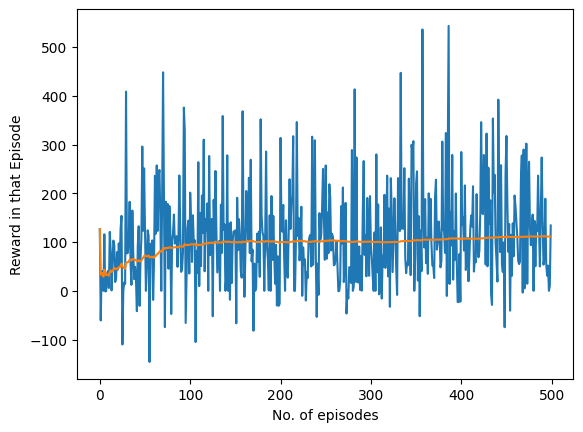

In [18]:
print ("")
print ("Rewards")
plt.plot(Rewards)
plt.plot(avg_rewards)
# plt.figsize((12,8))
plt.xlabel('No. of episodes')
plt.ylabel('Reward in that Episode')
plt.show()

Test no. 0
Qlearning path
<__main__.State object at 0x7efc68e380d0> 4 <__main__.State object at 0x7efc68e39690> 40.525624108713245
<__main__.State object at 0x7efc68e39690> 4 <__main__.State object at 0x7efc68e386a0> 40.31537446522795
<__main__.State object at 0x7efc68e386a0> 6 <__main__.State object at 0x7efc68e28a60> -2.133111246630783
<__main__.State object at 0x7efc68e28a60> 6 <__main__.State object at 0x7efc68e290f0> 53.873991427783146
Random path
<__main__.State object at 0x7efc68e380d0> 4 <__main__.State object at 0x7efc68e39690> 40.525624108713245
<__main__.State object at 0x7efc68e39690> 0 <__main__.State object at 0x7efc68e3a7d0> 18.13795891136698
<__main__.State object at 0x7efc68e3a7d0> 2 <__main__.State object at 0x7efc68e3bee0> 6.695979072383615
Test no. 1
Qlearning path
<__main__.State object at 0x7efc68e3a8f0> 6 <__main__.State object at 0x7efc68e28ac0> 26.68161948594498
<__main__.State object at 0x7efc68e28ac0> 3 <__main__.State object at 0x7efc68e38130> 44.16089357742

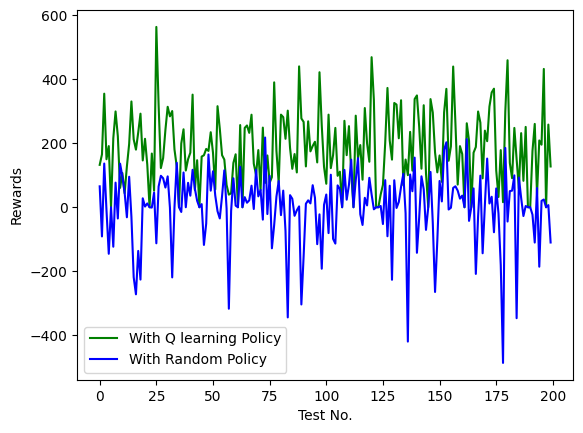

In [19]:
Rewards_Qpolicy=[]
Rewards_RandomPolicy=[]
for test_no in range(200):
    print ("Test no.",test_no)
    S=random.choice(state_space)
    S_random=S
    step=0
    r=0
    r_random=0

    print("Qlearning path")
    while(S.status!=tuple(np.ones(no_items)) and step<200):
        A=best_policy[S]
        S_,rew=takeaction(S,A)
        # rew=R[(S,A,S_)]
        print (S,A,S_,rew)
        S=S_
        if rew==None:
            rew=0
        r+=rew
        step+=1
    Rewards_Qpolicy.append(r)

    print("Random path")
    step=0
    while(S_random.status!=tuple(np.ones(no_items)) and step<200):
        A_random=random.choice(actions)
        S_random_,rew=takeaction(S_random,A_random)
        print (S_random,A_random,S_random_,rew)
        S_random=S_random_
        # rew=R[(S_random,A_random,S_random_)]

        if rew==None:
            rew=0
        r_random+=rew
        step+1
    Rewards_RandomPolicy.append(r_random)

print ("")
print ("Rewards ")
plt.plot(Rewards_Qpolicy,color='g',label='With Q learning Policy')
plt.plot(Rewards_RandomPolicy,color='b',label='With Random Policy')
plt.xlabel('Test No.')
plt.ylabel('Rewards')
plt.legend()
plt.show()

In [22]:
S=state_space[0]
S_random=S
step=0
r=0
r_random=0

print("Qlearning path")
while(S.status!=tuple(np.ones(no_items)) and step<200):
    A=best_policy[S]
    S_,rew=takeaction(S,A)
    # rew=R[(S,A,S_)]
    print ((S.shop, S.status),A,(S_.shop, S_.status),rew)
    S=S_
    if rew==None:
        rew=0
    r+=rew
    step+=1

print(f"reward = {r}")


print("Random path")
step=0
while(S_random.status!=tuple(np.ones(no_items)) and step<200):
    A_random=random.choice(actions)
    S_random_,rew=takeaction(S_random,A_random)
    print ((S_random.shop, S_random.status),A_random,(S_random_.shop, S_random_.status),rew)
    S_random=S_random_
    # rew=R[(S_random,A_random,S_random_)]
    if rew==None:
        rew=0
    r_random+=rew
    step+1
print(f"reward = {r_random}")

Qlearning path
(0, (0, 0, 0, 0)) 0 (0, (0, 1, 0, 0)) 20.026262024001404
(0, (0, 1, 0, 0)) 0 (0, (1, 0, 0, 0)) 20.039393036002103
(0, (1, 0, 0, 0)) 0 (0, (1, 1, 0, 0)) 30.026262024001404
(0, (1, 1, 0, 0)) 0 (1, (0, 0, 0, 0)) None
(1, (0, 0, 0, 0)) 1 (1, (1, 0, 0, 0)) 25.843884221590287
(1, (1, 0, 0, 0)) 6 (6, (1, 1, 0, 1)) 23.931633390049996
(6, (1, 1, 0, 1)) 6 (6, (1, 1, 1, 0)) 46.45665237963857
(6, (1, 1, 1, 0)) 6 (6, (1, 1, 1, 1)) 53.873991427783146
reward = 220.1980785030669
Random path
(0, (0, 0, 0, 0)) 4 (4, (1, 0, 1, 0)) 18.913302425304664
(4, (1, 0, 1, 0)) 4 (4, (1, 0, 1, 1)) 40.31537446522795
(4, (1, 0, 1, 1)) 4 (4, (1, 1, 0, 0)) 30.210249643485298
(4, (1, 1, 0, 0)) 1 (1, (1, 1, 0, 1)) -24.60358406053106
(1, (1, 1, 0, 1)) 4 (4, (1, 1, 1, 0)) -29.921844173408104
(4, (1, 1, 1, 0)) 3 (3, (1, 1, 1, 1)) 8.157621894823986
reward = 43.07112019490273
